In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import Button, HBox, VBox, Output
from IPython.display import display
import pickle 
from matplotlib.path import Path
from PIL import Image
import cv2

import glob
import os
import h5py

import torch
from torchvision import transforms, models
from PIL import Image
from sklearn.cluster import DBSCAN
import numpy as np
import shutil

from sklearn.decomposition import PCA

from utils import show_mirror, add_box_around_mirror

In [3]:
f = h5py.File("webcam_images.h5", "r")
feats = []
for entry_name in f["images"]:
    img_array = f["images"][entry_name]['mirrors']['mirror_172'][:].flatten()/255
    feats.append(img_array)

feats = np.stack(feats)
f.close()

In [4]:
feats.shape

(203, 272)

In [5]:
feats.dtype

dtype('float64')

In [31]:
feats_by_mirror = {}

with h5py.File("webcam_images.h5", "r") as f:
    for entry_name in f["images"]:
        mirrors_group = f["images"][entry_name]["mirrors"]
        for mirror_name in mirrors_group:
            array = mirrors_group[mirror_name][:].flatten() / 255.0
            feats_by_mirror.setdefault(mirror_name, []).append(array)

for key in feats_by_mirror:
    feats_by_mirror[key] = np.stack(feats_by_mirror[key])
        

In [44]:
labels_by_mirror = {}

for key in feats_by_mirror.keys():
    feats = feats_by_mirror[key]
    clust = DBSCAN(eps=1.75, min_samples=2).fit(feats)
    labels_by_mirror[key] = clust.labels_

In [46]:
labels_by_mirror["mirror_180"]

array([ 0, -1,  1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        3,  3,  4,  4, -1,  5,  5, -1, -1,  6,  6,  6, -1,  6, -1, -1, -1,
       -1,  1, -1, -1, -1, -1,  7,  7, -1,  8,  0,  0, -1,  8,  0,  0,  0,
        0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        5,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  5,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0,  9, 10,
       -1, -1, 11, -1, -1, -1, 12,  5, -1, -1, -1, 10, 11,  5, -1, -1, 12,
        5, 13, 12, -1, 14, 14, -1, -1, 15, 15, -1, -1, 13, -1, -1, -1, 16,
       16, -1,  5,  5, -1, -1,  5, -1,  5,  5, -1, -1, 17, -1, 17, 18, 18,
        1, 18, -1, -1,  5, -1, -1, -1, -1, 19, 19, 13, -1, -1,  5,  5,  5,
       -1,  5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  5,  2, -1])

In [16]:
feats_by_mirror["mirror_180"].shape

(203, 288)

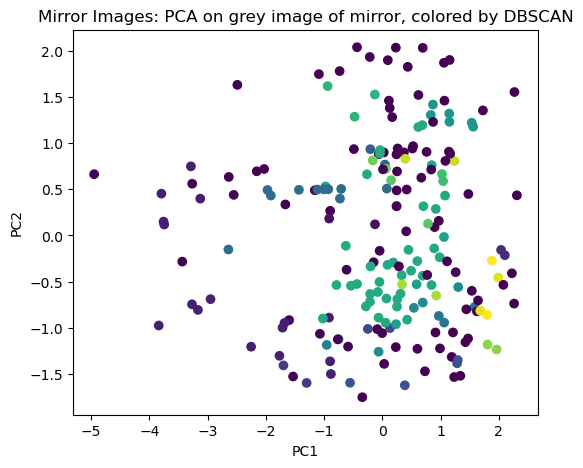

In [43]:
feats = feats_by_mirror["mirror_181"]

# 3. Reduce to 2D for plotting
pca = PCA(n_components=2)
proj = pca.fit_transform(feats)

# 4. Cluster with DBSCAN (eps/min_samples may need tuning)
clust = DBSCAN(eps=1.75, min_samples=2).fit(feats)
labels = clust.labels_  # -1 = anomaly, 0,1,2… = clusters

# 5. Scatter‐plot
plt.figure(figsize=(6,5))
plt.scatter(proj[:,0], proj[:,1], c=labels)
plt.title("Mirror Images: PCA on grey image of mirror, colored by DBSCAN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [42]:
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0, -1, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  2,
        2,  2,  0,  0,  2, -1,  0,  2,  0,  0,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [51]:
f = h5py.File("webcam_images.h5", "r")

In [52]:
keys = list(f["images"].keys())

In [53]:
f["images"][keys[5]]["image"]

<HDF5 dataset "image": shape (480, 830), type "|u1">

In [55]:
event_id = 5
f["images"][keys[event_id]]["image"]

<HDF5 dataset "image": shape (480, 830), type "|u1">

In [60]:
keys[event_id]

'entry_102'

In [61]:
labels_by_mirror["mirror_12"][event_id]

np.int64(0)

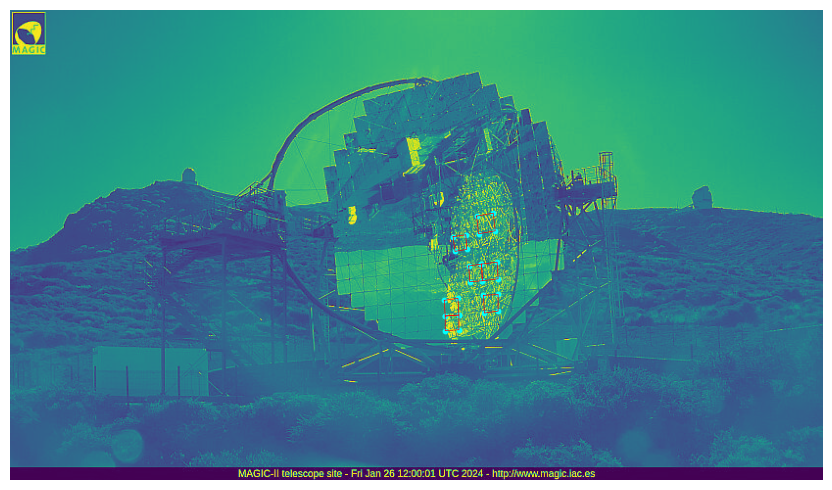

In [87]:
list_of_mirrors = []
event_id = 130
for key in labels_by_mirror.keys():
    label = labels_by_mirror[key][event_id]
    if label == -1:
        #print(key, label)
        list_of_mirrors.append(int(key.split("_")[-1]))
        
add_box_around_mirror(f["images"][keys[event_id]]["image"][:], list_of_mirrors)

[]


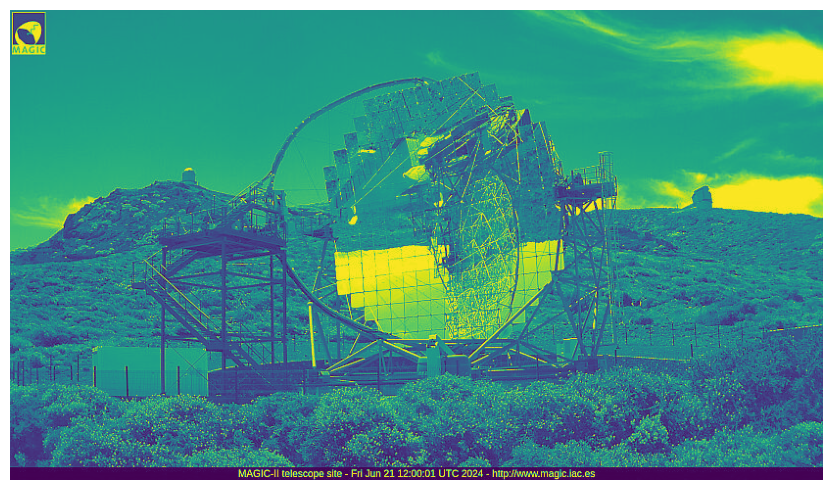

[112, 129, 130, 147, 162, 163, 164, 165, 179, 180, 181, 198, 199, 200, 213, 214, 215, 229, 231, 232, 233, 246, 247, 248, 249, 263, 264, 265, 266, 280, 281, 82]


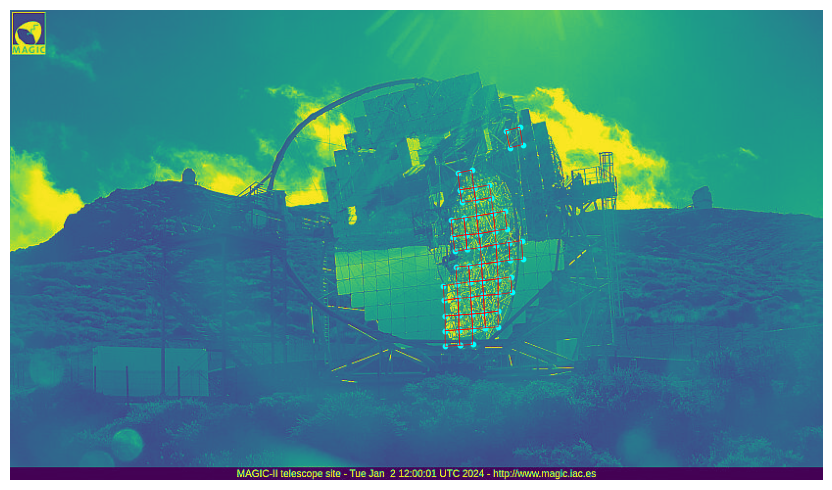

[]


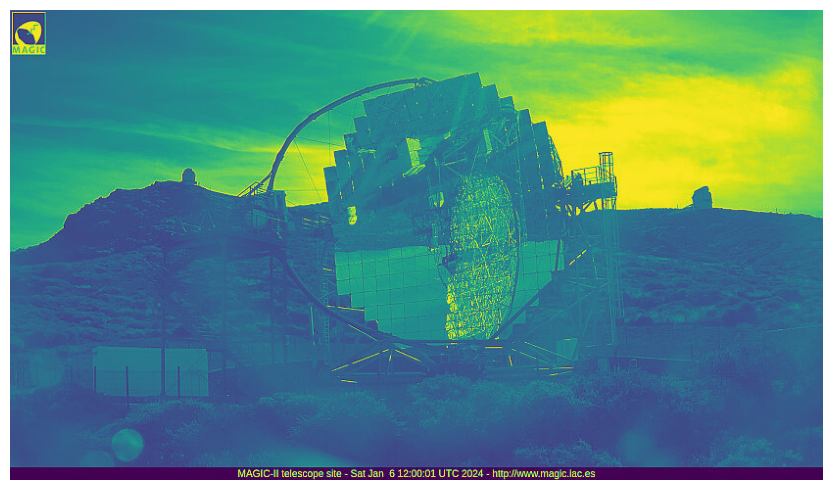

[112, 113, 129, 130, 162, 163, 164, 165, 166, 179, 196, 215, 47, 65, 81]


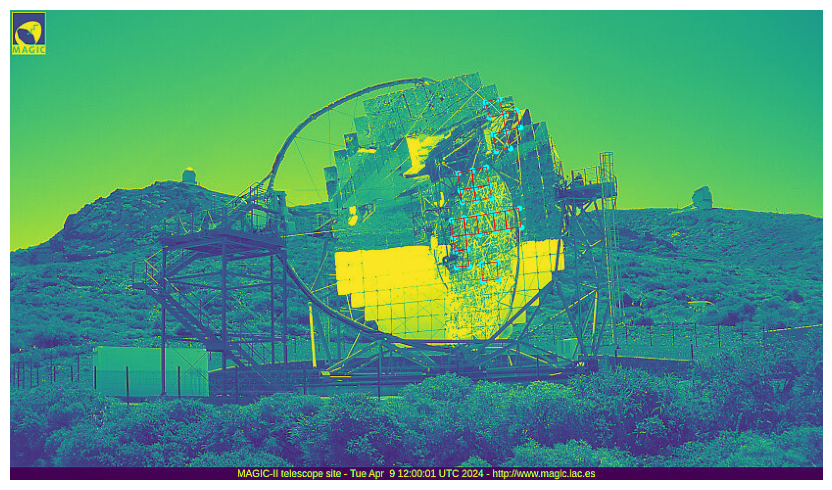

[112, 113, 114, 129, 130, 131, 146, 147, 162, 163, 164, 165, 178, 179, 180, 181, 195, 196, 197, 198, 199, 213, 214, 215, 216, 248, 249, 61, 94]


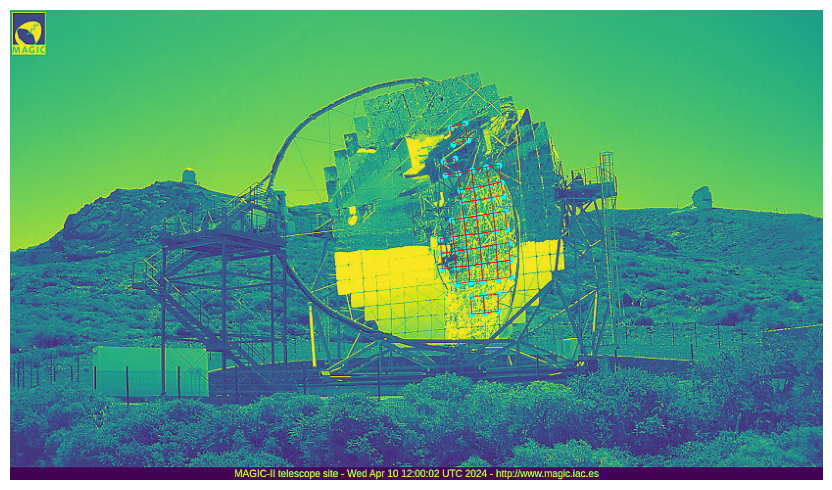

In [90]:
for event_id in range(0, 5):
    list_of_mirrors = []
    for key in labels_by_mirror.keys():
        label = labels_by_mirror[key][event_id]
        if label == -1:
            #print(key, label)
            list_of_mirrors.append(int(key.split("_")[-1]))
    
    print(list_of_mirrors)        
    add_box_around_mirror(f["images"][keys[event_id]]["image"][:], list_of_mirrors)

# Find the bast parameters

In [2]:
f = h5py.File("webcam_images.h5", "r")
feats = []
for entry_name in f["images"]:
    img_array = f["images"][entry_name]['mirrors']['mirror_172'][:].flatten()/255
    feats.append(img_array)

feats = np.stack(feats)
f.close()